# The Jester Dataset

# Recommender Systems
* Youtube
    * Clustering 
        * Recommends videos in your preferred languages
    * Interview on the Algorithm [Here](https://www.youtube.com/watch?v=h2SscdSVzE8)
* Shopping
* Amazon
* Netflix
* Spotify
    * Interview with DS at Spotify [Here](https://www.youtube.com/watch?v=_TWgsvF4hBQ)
* Ads

# Questions
* are there specific algorithms? what is happening under the hood?
* What does a train/test split look like?
    * predict ratings
    * train on some chunk of rated data
    * test on another chunk of rated data

![](https://vignette.wikia.nocookie.net/helmet-heroes/images/9/9b/Jester_Hat.png/revision/latest/scale-to-width-down/340?cb=20131023213944)

Today we will be building a recommendation system using User ratings of jokes.

By the end of this notebook, we will know how to 
- Format our data for user:user recommendation
- Find the cosine similarity between two vectors
- Use K Nearest Neighbor to indentify vector similarity
- Filter a dataframe to identify the highest rated joke based on K most similar users.

In [59]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### About user data
Format:

- Ratings are real values ranging from -10.00 to +10.00 (the value "99" corresponds to "null" = "not rated").
- One row per user
- The first column gives the number of jokes rated by that user. The next 100 columns give the ratings for jokes 01 - 100.
- The sub-matrix including only columns {5, 7, 8, 13, 15, 16, 17, 18, 19, 20} is dense. Almost all users have rated those jokes (see discussion of "universal queries" [here](http://eigentaste.berkeley.edu/)).


In [60]:
df = pd.read_csv('./data/jesterfinal151cols.csv', header=None)
df = df.fillna(99)

In [63]:
# Rows in our table -> Individual User's ratings of all 150 jokes
# Columns in our table -> Individual Jokes

# two sets of vectors
# user vectors
# joke vectors

In [61]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,62,99,99,99,99,0.21875,99,-9.28125,-9.28125,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
1,34,99,99,99,99,-9.68750,99,9.93750,9.53125,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
2,18,99,99,99,99,-9.84375,99,-9.84375,-7.21875,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
3,82,99,99,99,99,6.90625,99,4.75000,-5.90625,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
4,27,99,99,99,99,-0.03125,99,-9.09375,-0.40625,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0


### Joke data

In [62]:
jokes = pd.read_table('./data/jester_items.tsv', header = None)
jokes.head()

,0,1
0,1:,"A man visits the doctor. The doctor says, ""I h..."
1,2:,This couple had an excellent relationship goin...
2,3:,Q. What's 200 feet long and has 4 teeth? A. Th...
3,4:,Q. What's the difference between a man and a t...
4,5:,Q. What's O. J. Simpson's web address? A. Slas...


The 0 column is the join column we need to connect with the user dataframe. 

I could clean the column, but it would be easier to just set our index to a range  of numbers.

In [64]:
jokes.index = [x for x in range(1,150)]

jokes.drop(0, axis = 1, inplace = True)

In [65]:
jokes.head()

,1
1,"A man visits the doctor. The doctor says, ""I h..."
2,This couple had an excellent relationship goin...
3,Q. What's 200 feet long and has 4 teeth? A. Th...
4,Q. What's the difference between a man and a t...
5,Q. What's O. J. Simpson's web address? A. Slas...


Nice.

### Cosine similarity

Cosine similarty = 1 - cosinedistance

#### What does cosine similarity measure?
- The angle between two vectors
    - if cosine(v1, v2) == 0 -> perpendicular
    - if cosine(v1, v2) == 1 -> same direction
    - if cosine(v1, v2) == -1 -> opposite direction

Let's create two vectors and find their cosine distance

In [96]:
v1 = np.array([1, 2])
v2 = np.array([1, 2.5])
# (-1, -2) # v1, v2 -> similarity is -1
# (8, 0.5)
# (3, 1)
# v2 = np.array([-3, -6])

distance = cosine_distances(v1.reshape(1, -1), v2.reshape(1, -1))
distance

array([[0.00345424]])

### Let's visualize our vectors in space using quiver plots

In [97]:
V=np.array([v1, v2])
V

array([[1. , 2. ],
       [1. , 2.5]])

In [98]:
origin = [0], [0]

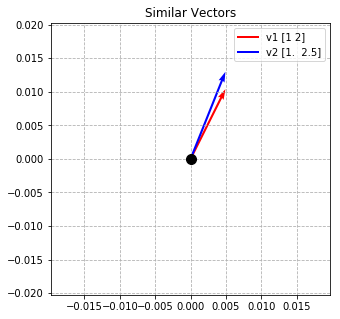

In [101]:
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]

plt.figure(figsize=(5, 5))
plt.grid(linestyle='dashed', zorder=0)
plt.scatter(*origin, s=100, c='k', zorder=2)
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b'], scale=8, zorder=1)
plt.legend(custom_lines, [f'v1 {v1}', f'v2 {v2}'])
plt.title("Similar Vectors")
plt.show()

In [102]:
similarity = 1 - cosine_distances(v1.reshape(1, -1), v2.reshape(1, -1))
similarity

array([[0.99654576]])

There is also an function for this that we can use.

In [103]:
cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))

array([[0.99654576]])

### How do we build a recommender system?
- How do we recommend a joke to userA?
    - user to user ->
        - find users that are similar to userA
        - recommend highly rated jokes that userA has not rated by those users to userA

### Let's condition the data for a recommender system


In [105]:
display(df.head(2))
df.shape

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,62,99,99,99,99,0.21875,99,-9.28125,-9.28125,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
1,34,99,99,99,99,-9.68750,99,9.93750,9.53125,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0


(50692, 151)

In [111]:
np.where(df.iloc[0, :]<=10)[0].shape

(62,)

In [112]:
# build a flow for a given user then turn this into a function

## User we would like to recommend a joke to
user_index = np.random.randint(0, df.shape[0])
print(f"User {user_index} is our random user")

## Drop column that totals the numbers of jokes each user has rated. 
## Isolate the row for the desired user
userA = df.drop(0, axis=1).loc[user_index, :]

# let's get the other users
others = df.drop(0, axis=1).drop(index=user_index, axis=0)

User 21597 is our random user


In [113]:
userA

1      99.0
2      99.0
3      99.0
4      99.0
5      99.0
       ... 
146    99.0
147    99.0
148    99.0
149    99.0
150    99.0
Name: 21597, Length: 150, dtype: float64

In [114]:
others

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
0,99,99,99,99,0.21875,99,-9.28125,-9.28125,99,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.00000,99.0,99.0000
1,99,99,99,99,-9.68750,99,9.93750,9.53125,99,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.00000,99.0,99.0000
2,99,99,99,99,-9.84375,99,-9.84375,-7.21875,99,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.00000,99.0,99.0000
3,99,99,99,99,6.90625,99,4.75000,-5.90625,99,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.00000,99.0,99.0000
4,99,99,99,99,-0.03125,99,-9.09375,-0.40625,99,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.00000,99.0,99.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50687,99,99,99,99,99.00000,99,-5.93750,-3.71875,99,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,-1.15625,99.0,-1.1875
50688,99,99,99,99,99.00000,99,-5.71875,-8.15625,99,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,3.06250,99.0,99.0000
50689,99,99,99,99,99.00000,99,0.09375,0.09375,99,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.00000,99.0,99.0000
50690,99,99,99,99,99.00000,99,-0.12500,-0.12500,99,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.00000,99.0,99.0000


In [115]:
# let's find the nearest neighbors
knn = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
knn.fit(others)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

Great! Now we can use the vectors of ratings for userA as an input to our knn model.

The knn model returns the distance between userA and the nears K neighbors as well as their index.

In [116]:
distances, indices = knn.kneighbors(userA.values.reshape(1, -1))
distances, indices = distances[0], indices[0]


print('---------------------------------------------------------------------------------------------')
print("userA's K nearest neighbors:", distances) 
print('---------------------------------------------------------------------------------------------')
print("Index for nearest neighbors:",indices)
print('---------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------
userA's K nearest neighbors: [4.93060678e-05 6.27067151e-05 8.14612696e-05 8.36617885e-05
 8.48456414e-05]
---------------------------------------------------------------------------------------------
Index for nearest neighbors: [22785 34779 34921 21757 17348]
---------------------------------------------------------------------------------------------


#### Now that we have our most similar users, what's next?

#### Find their highest rated items that aren't rated by userA

In [117]:
# let's get jokes not rated by userA
jokes_not_rated = np.where(userA==99)[0]
jokes_not_rated

array([  0,   1,   2,   3,   4,   5,   8,   9,  10,  11,  13,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,
        49,  50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  62,  63,
        64,  65,  66,  67,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149])

Next we need to isolate the nearest neighbors in our data, and examine their ratings for jokes userA has not rated.

In [119]:
user_jokes = df.loc[indices, jokes_not_rated].drop(0, axis=1)
user_jokes

,1,2,3,4,5,8,9,10,11,13,...,140,141,142,143,144,145,146,147,148,149
22785,99,99,99,99,99.0,-8.40625,99,99,99,-7.65625,...,99.0,99.0,99.0,2.3125,99.00000,2.875,99.0,99.0,1.40625,4.125
34779,99,99,99,99,99.0,-5.81250,99,99,99,2.18750,...,99.0,99.0,99.0,99.0000,-1.65625,99.000,99.0,99.0,99.00000,99.000
34921,99,99,99,99,99.0,-3.53125,99,99,99,-5.65625,...,99.0,99.0,99.0,99.0000,-4.21875,-3.250,99.0,99.0,99.00000,99.000
21757,99,99,99,99,99.0,-4.12500,99,99,99,1.62500,...,99.0,99.0,99.0,99.0000,99.00000,99.000,99.0,99.0,99.00000,99.000
17348,99,99,99,99,99.0,0.68750,99,99,99,1.43750,...,99.0,99.0,99.0,99.0000,99.00000,99.000,99.0,99.0,99.00000,99.000


Let's total up the ratings of each joke!

To do this, we need to replace 99 values with 0

In [120]:
ratings = user_jokes.replace(99, 0).sum()

Right now, the user_jokes dataframe has rows set to individual users and jokes set as columns.

We want to look at the jokes of each of these users. To do that, let's transform our user_jokes dataframe

In [121]:
user_jokes = user_jokes.T

user_jokes.head()

,22785,34779,34921,21757,17348
1,99.0,99.0,99.0,99.0,99.0
2,99.0,99.0,99.0,99.0,99.0
3,99.0,99.0,99.0,99.0,99.0
4,99.0,99.0,99.0,99.0,99.0
5,99.0,99.0,99.0,99.0,99.0


Great! Now we add the joke ratings as a column to our user_jokes dataframe

In [122]:
user_jokes['total'] = ratings

In [126]:
user_jokes.head()

,22785,34779,34921,21757,17348,total
1,99.0,99.0,99.0,99.0,99.0,0.0
2,99.0,99.0,99.0,99.0,99.0,0.0
3,99.0,99.0,99.0,99.0,99.0,0.0
4,99.0,99.0,99.0,99.0,99.0,0.0
5,99.0,99.0,99.0,99.0,99.0,0.0


In [127]:
user_jokes.iloc[50:70]

,22785,34779,34921,21757,17348,total
63,6.46875,99.0,99.00000,99.000,99.00000,6.46875
64,99.00000,99.0,99.00000,99.000,99.00000,0.00000
65,99.00000,99.0,99.00000,99.000,99.00000,0.00000
66,3.59375,99.0,7.68750,99.000,99.00000,11.28125
67,99.00000,99.0,99.00000,99.000,99.00000,0.00000
69,2.12500,99.0,4.09375,6.875,7.21875,20.31250
70,99.00000,99.0,99.00000,99.000,99.00000,0.00000
71,99.00000,99.0,99.00000,99.000,99.00000,0.00000
72,6.09375,99.0,4.53125,99.000,99.00000,10.62500
73,99.00000,99.0,99.00000,99.000,99.00000,0.00000


Using the method .idxmax(), we return the index for the joke with the highest rating!

In [124]:
recommend_index = user_jokes['total'].idxmax()
recommend_index

69

In [128]:
# checking our work
user_jokes.sort_values(by='total', ascending=False).head()

,22785,34779,34921,21757,17348,total
69,2.12500,99.0000,4.09375,6.87500,7.21875,20.31250
114,5.93750,6.4375,-0.25000,5.78125,1.50000,19.40625
49,99.00000,99.0000,8.59375,8.84375,99.00000,17.43750
36,5.34375,2.6250,3.56250,99.00000,5.59375,17.12500
127,8.93750,99.0000,99.00000,0.87500,5.12500,14.93750


Now all we have to do is plug in the index to our jokes dataframe, and return the recommended joke!

In [129]:
jokes.iloc[recommend_index][1]

'Employer to applicant: "In this job we need someone who is responsible." Applicant: "I\'m the one you want. On my last job, every time anything went wrong, they said I was responsible."'

In [133]:
jokes.iloc[36][1]

'A Jewish young man was seeing a psychiatrist for an eating and sleeping disorder. "I am so obsessed with my mother...As soon as I go to sleep, I start dreaming, and everyone in my dream turns into my mother. I wake up in such a state, and all I can do is go downstairs and eat a piece of toast." The psychiatrist replies, "What, just one piece of toast, for a big boy like you?"'

# We did it!

### Assignment

Please create a function called recommend_joke that will receive a user index, and spit out the recommended joke.

I recommend dividing up each step of the process coded out above ito seperate functions. This is standard practice in industry, makes our code easier to read, and makes testing for bugs an easier process. 

Please respond in your cohort slack channel with a recommended joke, and the index for the joke. 
Check to see if your recommendations match those of your cohort members.

In [ ]:
# build a flow for a given user then turn this into a function


In [ ]:
recommend_joke(400)